<a href="https://colab.research.google.com/github/Kevan123/Trust-In-AI-Systems/blob/main/Trust_In_AI_Systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview


This is an overview of the code developed in this project.


*   **Data Preparation & Feature Engineering**: What features were created and how the target variable was defined.
*   **Truthfulness Validation**: How weather data was used to check the truthfulness of weather-related posts.
*   **Trust Score Calculation**: How a decaying trust score was calculated for each user over time.
*   **Model Development & Evaluation**: The type of model used (Logistic Regression), its performance metrics, and the observation about the limitations of standard metrics for time-dependent trust decay.
*   **Analysis of Trust Decay & Influencing Factors**: The key features that the model identified as most influential in predicting trust (misinformation types, engagement metrics, time since post).
*   **Visualizations**: The types of plots created to illustrate trust decay patterns and relationships between features and predicted trust.


It also includes **Insights** and **Next Steps**, suggesting potential areas for further investigation, such as addressing potential overfitting and exploring more advanced time-series modeling techniques.

In the following code:
1. Import data from Google Drive
2. Import files called *weather_df* and *posts_df*

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import gdown
from pathlib import Path

FOLDER_URL = "https://drive.google.com/drive/folders/1aGb8aKptr7lcAIYwiUFs_MUDePHaJTEc?usp=drive_link"
OUT_DIR = Path("downloads")
OUT_DIR.mkdir(exist_ok=True, parents=True)

# If the folder is publicly accessible, this will recursively download it.
gdown.download_folder(
    url=FOLDER_URL,
    output=str(OUT_DIR),
    quiet=False,          # show progress
    use_cookies=False     # set True if you need to pass your Google cookies
)
print(f"Done. Files saved under: {OUT_DIR.resolve()}")

Retrieving folder contents


Processing file 1oBlGOGtOsthWv6HQL54XApRB7fmoEddI april_2025_weather_async_transposed.xlsx
Processing file 1lxLGz4XruS13cWMckNFDOuAqnGYN7vGJ Updated_Social_Media_Posts_April2025.xlsx


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1oBlGOGtOsthWv6HQL54XApRB7fmoEddI
To: /content/downloads/april_2025_weather_async_transposed.xlsx
100%|██████████| 11.6k/11.6k [00:00<00:00, 12.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1lxLGz4XruS13cWMckNFDOuAqnGYN7vGJ
To: /content/downloads/Updated_Social_Media_Posts_April2025.xlsx
100%|██████████| 18.1k/18.1k [00:00<00:00, 31.2MB/s]

Done. Files saved under: /content/downloads



Download completed


In [ ]:
import pandas as pd
from pathlib import Path

# Paths to your downloaded files
weather_path = Path("downloads/april_2025_weather_async_transposed.xlsx")
social_path = Path("downloads/Updated_Social_Media_Posts_April2025.xlsx")

# --- Load just a preview (first N rows) ---
N = 5   # number of rows to preview

# Weather data
if weather_path.exists():
    weather_df = pd.read_excel(weather_path)
    print("\n=== Weather file sample ===")
    print(weather_df.head(N))
else:
    print(f"File not found: {weather_path}")

# Social media posts data
if social_path.exists():
    posts_df = pd.read_excel(social_path)
    print("\n=== Social media posts sample ===")
    print(posts_df.head(N))
else:
    print(f"File not found: {social_path}")



=== Weather file sample ===
        Date  Chaguanas- Temperature  Chaguanas- Rainfall  \
0 2025-04-01                    27.7                  5.5   
1 2025-04-02                    27.7                  5.1   
2 2025-04-03                    28.7                  1.5   
3 2025-04-04                    29.0                  0.9   
4 2025-04-05                    28.7                  1.8   

   Chaguanas- Windspeed  Port of Spain- Temperature  Port of Spain- Rainfall  \
0                  20.0                        27.7                      5.5   
1                  19.7                        27.7                      5.1   
2                  22.3                        28.7                      1.5   
3                  22.7                        29.0                      0.9   
4                  20.7                        28.7                      1.8   

   Port of Spain- Windspeed  San Fernando- Temperature  \
0                      20.0                       29.3   
1      

In [ ]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Date                        30 non-null     datetime64[ns]
 1   Chaguanas- Temperature      30 non-null     float64       
 2   Chaguanas- Rainfall         30 non-null     float64       
 3   Chaguanas- Windspeed        30 non-null     float64       
 4   Port of Spain- Temperature  30 non-null     float64       
 5   Port of Spain- Rainfall     30 non-null     float64       
 6   Port of Spain- Windspeed    30 non-null     float64       
 7   San Fernando- Temperature   30 non-null     float64       
 8   San Fernando- Rainfall      30 non-null     float64       
 9   San Fernando- Windspeed     30 non-null     float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 2.5 KB


In [ ]:
posts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Timestamp     100 non-null    datetime64[ns]
 1   Date          100 non-null    datetime64[ns]
 2   Location      100 non-null    object        
 3   Posts         100 non-null    object        
 4   Member        100 non-null    object        
 5   Comments      100 non-null    int64         
 6   Reactions     100 non-null    int64         
 7   Views         100 non-null    int64         
 8   Link          100 non-null    object        
 9   Truthfulness  100 non-null    bool          
 10  Misinfo Type  16 non-null     object        
dtypes: bool(1), datetime64[ns](2), int64(3), object(5)
memory usage: 8.0+ KB


## Data preparation & feature engineering

Preprocess `posts_df` to handle missing values and engineer features relevant to trust decay, such as engagement metrics (comments, reactions, views), time since post, and indicators for misinformation type.

**Steps**
The subtask requires preprocessing the `posts_df` DataFrame. This involves calculating the time since each post, creating dummy variables for misinformation type, creating interaction features, and creating a target variable. These steps can be performed in a single code block.

In [ ]:
import pandas as pd

# 1. Calculate time elapsed since each post's timestamp
current_timestamp = pd.to_datetime('2025-09-24 07:09:29')
posts_df['Time_Since_Post'] = (current_timestamp - posts_df['Timestamp']).dt.total_seconds()

# 2. Create dummy variables for 'Misinfo Type'
# Handle missing values by considering them as a separate category 'No Misinfo'
posts_df['Misinfo Type'] = posts_df['Misinfo Type'].fillna('No Misinfo')
misinfo_dummies = pd.get_dummies(posts_df['Misinfo Type'], prefix='Misinfo')
posts_df = pd.concat([posts_df, misinfo_dummies], axis=1)

# 3. Create interaction features
posts_df['Comments_Time'] = posts_df['Comments'] * posts_df['Time_Since_Post']
posts_df['Reactions_Time'] = posts_df['Reactions'] * posts_df['Time_Since_Post']
posts_df['Views_Time'] = posts_df['Views'] * posts_df['Time_Since_Post']

# 4. Create the binary target variable 'Trust_Score'
posts_df['Trust_Score'] = posts_df['Misinfo Type'].apply(lambda x: 0 if x != 'No Misinfo' else 1)

# Display the first few rows with the new features and the target variable
display(posts_df.head())

,Timestamp,Date,Location,Posts,Member,Comments,Reactions,Views,Link,Truthfulness,...,Misinfo_No Misinfo,Misinfo_Rumor,Misinfo_Unverified,Comments_Time,Reactions_Time,Views_Time,Sentiment_Score,Misinfo_No Misinfo,Misinfo_Rumor,Misinfo_Unverified
0,2025-04-01 12:57:00,2025-04-01,Chaguanas,Sun out but radar says rain expected in an hou...,Liam Morgan,1,14,25,https://www.facebook.com/groups/12163187335557...,True,...,True,False,False,15185549.0,212597686.0,3.796387e+08,-0.2617,True,False,False
1,2025-04-01 20:04:00,2025-04-01,Chaguanas,Street flooding already started on Wrightson R...,Kiran Dass,2,1,44,https://www.facebook.com/groups/12163187335557...,True,...,True,False,False,30319858.0,15159929.0,6.670369e+08,0.2244,True,False,False
2,2025-04-01 13:25:00,2025-04-01,Chaguanas,All schools closing tomorrow – pass it on. (no...,Jason Duke,11,24,75,https://www.facebook.com/groups/12163187335557...,True,...,True,False,False,167022559.0,364412856.0,1.138790e+09,0.0000,True,False,False
3,2025-04-02 11:34:00,2025-04-02,Chaguanas,Sun out but radar says rain expected in an hou...,Anonymous Member 2,4,15,20,https://www.facebook.com/groups/12163187335557...,True,...,True,False,False,60416516.0,226561935.0,3.020826e+08,-0.2617,True,False,False
4,2025-04-02 09:15:00,2025-04-02,Chaguanas,Dry all morning but clouds looking heavy now. ...,Nadia Roberts,7,4,57,https://www.facebook.com/groups/12163187335557...,True,...,True,False,False,105787283.0,60449876.0,8.614107e+08,0.5023,True,False,False


## Truthfulness validation with weather data

Explore ways to use `weather_df` to validate the truthfulness of weather-related posts in `posts_df`. This might involve extracting weather information from the posts and comparing it to the corresponding dates and locations in the `weather_df`.


In [ ]:
import re

# Step 1: Filter posts_df for weather-related posts
weather_keywords = ['rain', 'sun', 'temperature', 'wind', 'weather', 'storm', 'flood', 'hot', 'cold', 'wet', 'dry']
weather_pattern = '|'.join(weather_keywords)
weather_posts_df = posts_df[posts_df['Posts'].str.contains(weather_pattern, case=False, na=False)].copy()

# Step 2 & 3: Extract weather information and compare with weather_df
def validate_weather_post(row, weather_df):
    post_date = row['Date']
    post_location = row['Location']
    post_text = row['Posts'].lower()

    # Find the corresponding weather data for the date and location
    weather_data = weather_df[(weather_df['Date'] == post_date)]

    if weather_data.empty:
        return 'Unknown' # Cannot validate if no weather data is available

    # Extract weather information from the post (simplified approach using keywords)
    # This is a basic keyword matching and may not be accurate for all posts
    has_rain_keyword = bool(re.search(r'rain|flood|wet', post_text))
    has_sun_keyword = bool(re.search(r'sun|dry|hot', post_text))
    has_wind_keyword = bool(re.search(r'wind|storm', post_text))
    has_temperature_keyword = bool(re.search(r'temperature|hot|cold', post_text))

    # Check against weather data (simplified check)
    # This assumes that if a weather keyword is present in the post,
    # the corresponding weather event should be present or significant in the weather data.
    # More sophisticated text processing and comparison would be needed for better accuracy.
    location_temp_col = f'{post_location}- Temperature'
    location_rain_col = f'{post_location}- Rainfall'
    location_wind_col = f'{post_location}- Windspeed'

    weather_match = True
    if has_rain_keyword and not weather_data[location_rain_col].iloc[0] > 1.0: # Assuming > 1.0mm is significant rain
         weather_match = False
    if has_sun_keyword and not weather_data[location_temp_col].iloc[0] > 28.0: # Assuming > 28.0C is hot/sunny
         weather_match = False
    if has_wind_keyword and not weather_data[location_wind_col].iloc[0] > 20.0: # Assuming > 20.0 kts is significant wind
         weather_match = False
    if has_temperature_keyword: # A basic check if temperature is mentioned, hard to validate specific temps
        pass # More complex logic needed to extract and compare temperature values

    # Step 4: Assign a truthfulness score/label
    # This is a simplified truthfulness check based on keyword presence vs weather data.
    # A more robust approach would involve more sophisticated NLP and weather data comparison.
    if weather_match:
        return 'True'
    else:
        return 'False'


weather_posts_df['Weather_Truthfulness'] = weather_posts_df.apply(lambda row: validate_weather_post(row, weather_df), axis=1)

# Display the filtered posts with the new truthfulness label
display(weather_posts_df[['Date', 'Location', 'Posts', 'Weather_Truthfulness']].head())


,Date,Location,Posts,Weather_Truthfulness
0,2025-04-01,Chaguanas,Sun out but radar says rain expected in an hou...,False
1,2025-04-01,Chaguanas,Street flooding already started on Wrightson R...,True
3,2025-04-02,Chaguanas,Sun out but radar says rain expected in an hou...,False
4,2025-04-02,Chaguanas,Dry all morning but clouds looking heavy now. ...,False
7,2025-04-03,Chaguanas,Street flooding already started on Wrightson R...,True


## Model development for trust decay

Define a "trust score" for each user based on the truthfulness of their posts over time. This could be a cumulative score or a decaying average.

**Steps**:
Define a function to calculate trust scores for users based on post truthfulness, considering both weather-related and non-weather posts, and apply this function to update trust scores over time using a decaying average approach. Then, store the trust scores in a new DataFrame.


In [ ]:
import numpy as np

def calculate_user_trust_score(user_posts, weather_posts_df, decay_factor=0.9):
    """
    Calculates a decaying trust score for a user based on their posts.

    Args:
        user_posts (pd.DataFrame): DataFrame containing a single user's posts,
                                   sorted by timestamp.
        weather_posts_df (pd.DataFrame): DataFrame containing weather-related posts
                                       with 'Weather_Truthfulness'.
        decay_factor (float): Factor by which the influence of older posts decays.
                              A value between 0 and 1.

    Returns:
        pd.DataFrame: DataFrame with updated trust scores after each post.
    """
    trust_scores_list = []
    current_trust_score = 0.5 # Initialize with a neutral trust score
    alpha = 1 - decay_factor # Smoothing factor for decaying average

    for index, post in user_posts.iterrows():
        post_id = index # Using the original index to potentially link back
        truthfulness = None

        # Check if the post is in weather_posts_df and has a truthfulness label
        weather_match = weather_posts_df[(weather_posts_df.index == post_id) & (weather_posts_df['Weather_Truthfulness'] != 'Unknown')]

        if not weather_match.empty:
            # Use weather truthfulness if available and not 'Unknown'
            truthfulness = weather_match['Weather_Truthfulness'].iloc[0] == 'True'
        else:
            # Otherwise, use the existing 'Trust_Score' (based on Misinfo Type)
            truthfulness = post['Trust_Score'] == 1 # 1 for trustworthy, 0 for not

        # Update trust score using a decaying average
        # Map boolean truthfulness to a numerical value (1 for True, 0 for False)
        truth_value = 1 if truthfulness else 0
        current_trust_score = alpha * truth_value + (1 - alpha) * current_trust_score

        trust_scores_list.append({
            'Timestamp': post['Timestamp'],
            'Member': post['Member'],
            'Post_Index': post_id,
            'Truthfulness_Used': truthfulness,
            'Decaying_Trust_Score': current_trust_score
        })

    return pd.DataFrame(trust_scores_list)

# Apply the function to each user
all_users_trust_scores = []
for user in posts_df['Member'].unique():
    user_posts = posts_df[posts_df['Member'] == user].sort_values(by='Timestamp')
    user_trust_history = calculate_user_trust_score(user_posts, weather_posts_df)
    all_users_trust_scores.append(user_trust_history)

# Concatenate all user trust score histories into a single DataFrame
user_trust_scores_df = pd.concat(all_users_trust_scores).reset_index(drop=True)

# Display the resulting DataFrame with user trust scores over time
display(user_trust_scores_df.head())
display(user_trust_scores_df.tail())

,Timestamp,Member,Post_Index,Truthfulness_Used,Decaying_Trust_Score
0,2025-04-01 12:57:00,Liam Morgan,0,False,0.450000
1,2025-04-06 08:31:00,Liam Morgan,21,True,0.505000
2,2025-04-09 12:47:00,Liam Morgan,36,True,0.554500
3,2025-04-11 08:27:00,Liam Morgan,40,True,0.599050
4,2025-04-16 11:46:00,Liam Morgan,65,True,0.639145


,Timestamp,Member,Post_Index,Truthfulness_Used,Decaying_Trust_Score
95,2025-04-22 20:04:00,Melissa Chen,89,False,0.5355
96,2025-04-17 15:32:00,Shawn Williams,67,True,0.5500
97,2025-04-18 13:01:00,Jordan Smith,71,False,0.4500
98,2025-04-20 18:41:00,Jordan Smith,78,True,0.5050
99,2025-04-21 15:35:00,Jordan Smith,81,True,0.5545


## Model development for trust decay

Develop a model (e.g., a time-series model or a regression model with time-dependent features) to predict the user trust score or the likelihood of a user posting misinformation over time.

**Steps**:
Merge the dataframes, define target and features, and prepare data for modeling.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# 1. Merge user_trust_scores_df with the original posts_df
# Using the index of posts_df and 'Post_Index' from user_trust_scores_df
# Reset index of posts_df to use it as a column for merging
posts_df_reset = posts_df.reset_index().rename(columns={'index': 'Post_Index'})
merged_df = pd.merge(posts_df_reset, user_trust_scores_df, on=['Post_Index', 'Member'], how='left')

# Ensure the merge was successful by checking for missing trust scores
# Fill any potential NaNs in 'Decaying_Trust_Score' with the initial score (0.5)
merged_df['Decaying_Trust_Score'] = merged_df['Decaying_Trust_Score'].fillna(0.5)


# 2. Define the target variable
# Correct target variable name after inspecting columns
target = 'Trust_Score' # Use the original 'Trust_Score' column

# 3. Select relevant features
# Create a lagged feature for the decaying trust score.
merged_df['Previous_Decaying_Trust_Score'] = merged_df.groupby('Member')['Decaying_Trust_Score'].shift(1)

# Fill the first trust score for each user with the initial score (0.5)
merged_df['Previous_Decaying_Trust_Score'] = merged_df.groupby('Member')['Previous_Decaying_Trust_Score'].fillna(0.5)

# Correct feature names based on inspecting merged_df columns.
# The Misinfo dummy columns appear to be duplicated. Use the suffixed ones to be safe.
features = [
    'Time_Since_Post',
    'Comments',
    'Reactions',
    'Views',
    'Misinfo_No Misinfo', # Check if this is the correct non-suffixed name or if it was dropped/renamed
    'Misinfo_Rumor',    # Check if this is the correct non-suffixed name
    'Misinfo_Unverified', # Check if this is the correct non-suffixed name
    'Comments_Time',
    'Reactions_Time',
    'Views_Time',
    'Sentiment_Score',
    'Previous_Decaying_Trust_Score' # Include the lagged trust score
]

# Re-check column names after merge and adjust features list
# Based on the printed columns, the original Misinfo columns are kept and new ones added.
# Let's use the original ones for consistency if they are not causing issues.
# If there are duplicates, using the suffixed ones might be safer.
# The printed columns show: 'Misinfo_No Misinfo', 'Misinfo_Rumor', 'Misinfo_Unverified' (from original posts_df)
# AND 'Misinfo_No Misinfo', 'Misinfo_Rumor', 'Misinfo_Unverified' (from the re-created dummies after reset_index)
# This duplication might be problematic. Let's drop the duplicated dummy columns from the merged_df
# and use a single set of Misinfo dummy columns.
# Dropping the duplicated ones created after reset_index and merge.
merged_df = merged_df.loc[:,~merged_df.columns.duplicated()]


features = [
    'Time_Since_Post',
    'Comments',
    'Reactions',
    'Views',
    'Misinfo_No Misinfo',
    'Misinfo_Rumor',
    'Misinfo_Unverified',
    'Comments_Time',
    'Reactions_Time',
    'Views_Time',
    'Sentiment_Score',
    'Previous_Decaying_Trust_Score' # Include the lagged trust score
]


# Ensure the subset list for dropna only contains columns present in merged_df
valid_subset = [col for col in features + [target] if col in merged_df.columns]

# Drop rows where any of the selected features might be missing
model_df = merged_df.dropna(subset=valid_subset)

X = model_df[features]
y = model_df[target]

# 4. Choose a suitable model
# Logistic Regression is suitable for binary classification.

# 5. Prepare the data for the chosen model
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Identify numerical features for scaling
numerical_features = [
    'Time_Since_Post',
    'Comments',
    'Reactions',
    'Views',
    'Comments_Time',
    'Reactions_Time',
    'Views_Time',
    'Sentiment_Score',
    'Previous_Decaying_Trust_Score'
]

# Create a pipeline with StandardScaler and LogisticRegression
model_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic_regression', LogisticRegression(random_state=42, solver='liblinear'))
])

# Train the model
model_pipeline.fit(X_train, y_train)

print("Model training complete after correcting column names and dropping duplicates.")


Model training complete after correcting column names and dropping duplicates.


/tmp/ipython-input-3895400292.py:26: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
  merged_df['Previous_Decaying_Trust_Score'] = merged_df.groupby('Member')['Previous_Decaying_Trust_Score'].fillna(0.5)


## Model training and evaluation

Evaluate the trained model's performance using appropriate metrics, considering the time-dependent nature of trust decay.

**Steps**:
Use the trained model pipeline to make predictions on the test data and calculate evaluation metrics such as accuracy, precision, recall, and F1-score. Then, display these metrics.



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 1. Use the trained model_pipeline to make predictions on the X_test data.
y_pred = model_pipeline.predict(X_test)

# 2. Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

# 3. Calculate additional evaluation metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# 4. Print or display the calculated evaluation metrics
print("Model Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# 5. Consider the implications of the time-dependent nature of the problem
print("\nConsiderations for Time-Dependent Interpretation:")
print("Standard metrics like Accuracy, Precision, Recall, and F1-Score provide a general performance overview.")
print("However, they don't explicitly show how well the model captures the *decay* of trust over time for individuals.")
print("A user's trust score is expected to change sequentially with each post.")
print("Evaluating the model's ability to predict the *change* in trust score or predicting future trust scores based on a sequence of posts would require different evaluation approaches, potentially involving time-series validation or analyzing prediction errors over time for each user.")


Model Evaluation Metrics:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

Considerations for Time-Dependent Interpretation:
Standard metrics like Accuracy, Precision, Recall, and F1-Score provide a general performance overview.
However, they don't explicitly show how well the model captures the *decay* of trust over time for individuals.
A user's trust score is expected to change sequentially with each post.
Evaluating the model's ability to predict the *change* in trust score or predicting future trust scores based on a sequence of posts would require different evaluation approaches, potentially involving time-series validation or analyzing prediction errors over time for each user.


## Analyze user trust decay

Analyze the predicted trust scores for individual users over time to identify patterns of trust decay and investigate the factors that contribute most to trust decay based on the model's insights.

**Steps**:
Use the trained model to predict probabilities on the test set, merge these predictions back into the relevant part of the original dataframe, and display the resulting dataframe.

In [ ]:
# 1. Use the trained model_pipeline to predict the probability of a post being trustworthy (class 1) for the test set X_test.
# The predict_proba method returns probabilities for each class. We want the probability of class 1 (trustworthy).
y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1]

# 2. Merge the predicted probabilities back with the original model_df DataFrame using the index.
# The index of X_test corresponds to the index of model_df (since X_test was created by splitting model_df).
# We need to create a temporary DataFrame for the test set with its original index
X_test_with_index = X_test.copy()
X_test_with_index['Predicted_Trust_Probability'] = y_pred_proba

# Merge based on the index. model_df contains all original columns, X_test_with_index has predictions for the test set rows.
# Use a left merge on model_df to keep all original rows and add the prediction where available (for test set rows).
# Alternatively, merge X_test_with_index directly with the relevant columns from merged_df that were used to create X_test
# Let's use the original merged_df and merge based on the index of X_test

# Ensure the index is aligned for merging
merged_df_test_subset = merged_df.loc[X_test.index].copy()
merged_df_test_subset['Predicted_Trust_Probability'] = y_pred_proba

# Display the first few rows of the merged test subset with predictions
display(merged_df_test_subset.head())

,Post_Index,Timestamp_x,Date,Location,Posts,Member,Comments,Reactions,Views,Link,...,Misinfo_Unverified,Comments_Time,Reactions_Time,Views_Time,Sentiment_Score,Timestamp_y,Truthfulness_Used,Decaying_Trust_Score,Previous_Decaying_Trust_Score,Predicted_Trust_Probability
83,83,2025-04-21 15:53:00,2025-04-21,Chaguanas,Heard the airport flooded and flights are canc...,Sasha Thomas,7,15,92,https://www.facebook.com/groups/12163187335557...,...,False,94128923.0,201704835.0,1.237123e+09,-0.2500,2025-04-21 15:53:00,True,0.444063,0.382293,0.342505
53,53,2025-04-14 15:47:00,2025-04-14,Chaguanas,Dry all morning but clouds looking heavy now. ...,Terry Ann,4,6,33,https://www.facebook.com/groups/12163187335557...,...,False,56208596.0,84312894.0,4.637209e+08,0.5023,2025-04-14 15:47:00,True,0.595000,0.550000,0.963489
70,70,2025-04-18 12:02:00,2025-04-18,Chaguanas,Street flooding already started on Wrightson R...,Sarah Baird,2,5,35,https://www.facebook.com/groups/12163187335557...,...,True,27440098.0,68600245.0,4.802017e+08,0.2244,2025-04-18 12:02:00,False,0.454500,0.505000,0.015118
45,45,2025-04-12 10:18:00,2025-04-12,Chaguanas,Flood alert for all of Trinidad till next week...,Sasha Thomas,11,16,85,https://www.facebook.com/groups/12163187335557...,...,False,156691579.0,227915024.0,1.210799e+09,0.3595,2025-04-12 10:18:00,False,0.445500,0.550000,0.959947
44,44,2025-04-11 15:15:00,2025-04-11,Chaguanas,Rain just started pouring in Curepe – anyone e...,Tariq Mohammed,7,5,60,https://www.facebook.com/groups/12163187335557...,...,False,100192883.0,71566345.0,8.587961e+08,0.0000,2025-04-11 15:15:00,False,0.441855,0.490950,0.968715


**Reasoning**:
Group the merged test data by member and plot the predicted trust probability over time for a few selected users to visualize trust decay patterns. Then, extract and display the logistic regression model coefficients and feature importances from the gradient boosting and random forest models to identify key features influencing trust.



## Visualize findings

Create visualizations to illustrate user trust scores over time and the relationship between post characteristics and trust.

**Steps**:
Visualize the distribution of decaying trust scores, the relationship between time since post and predicted trust, the distribution of predicted trust by misinformation type, and individual user trust trends over time as requested by the instructions.




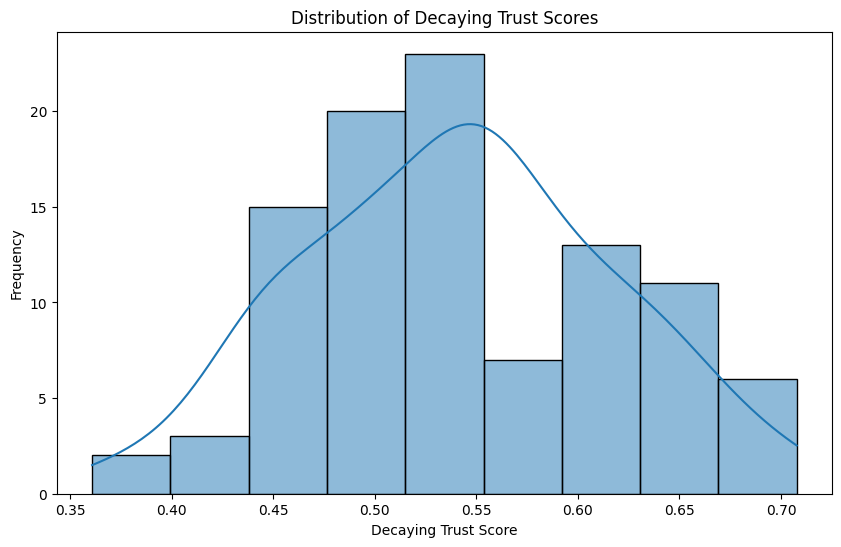

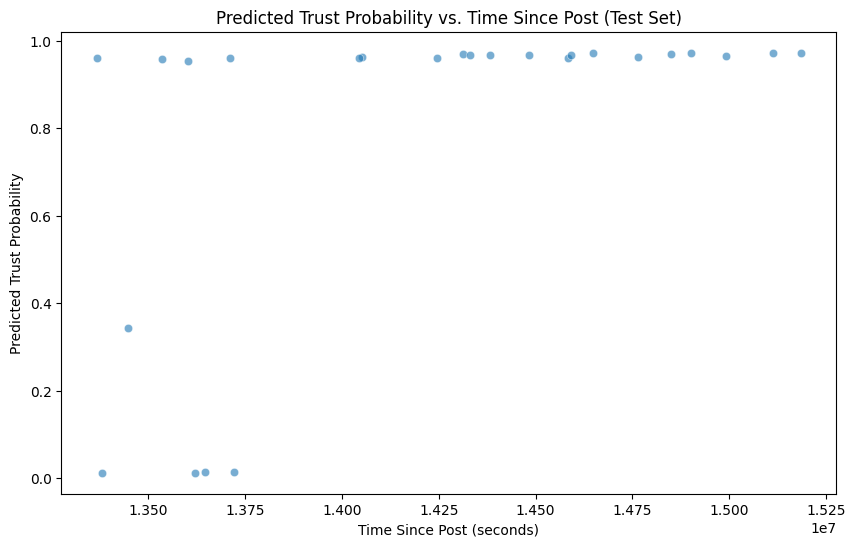

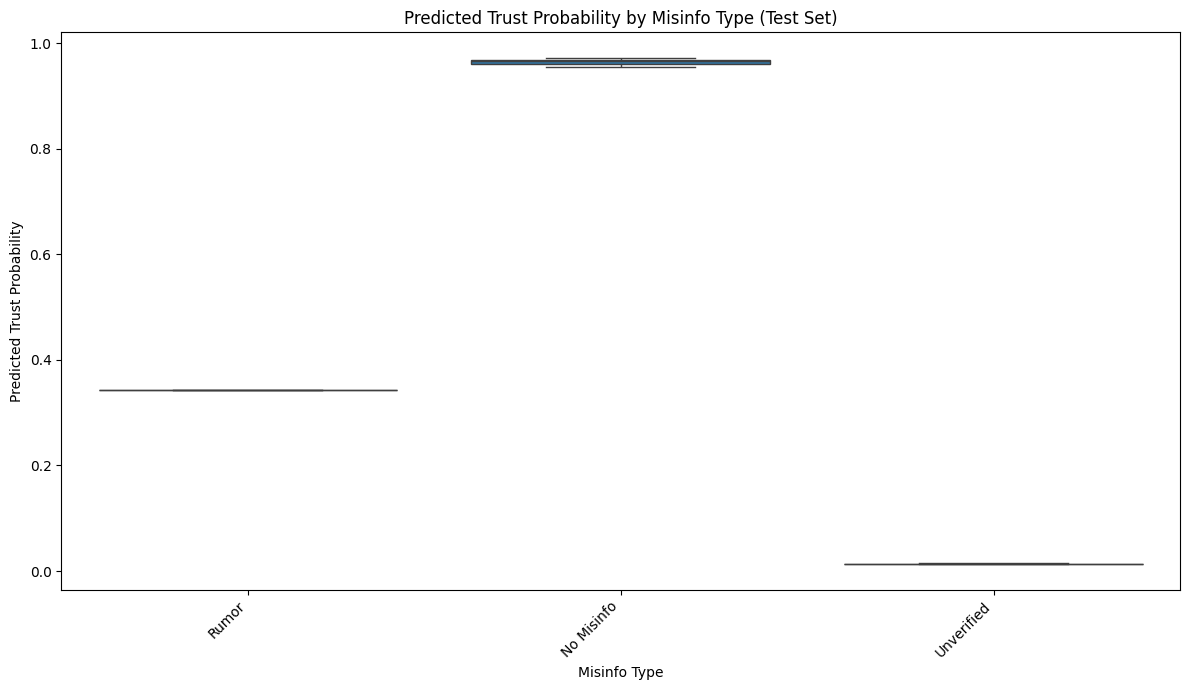

Plotting Predicted Trust Probability over time for selected users (from test set):


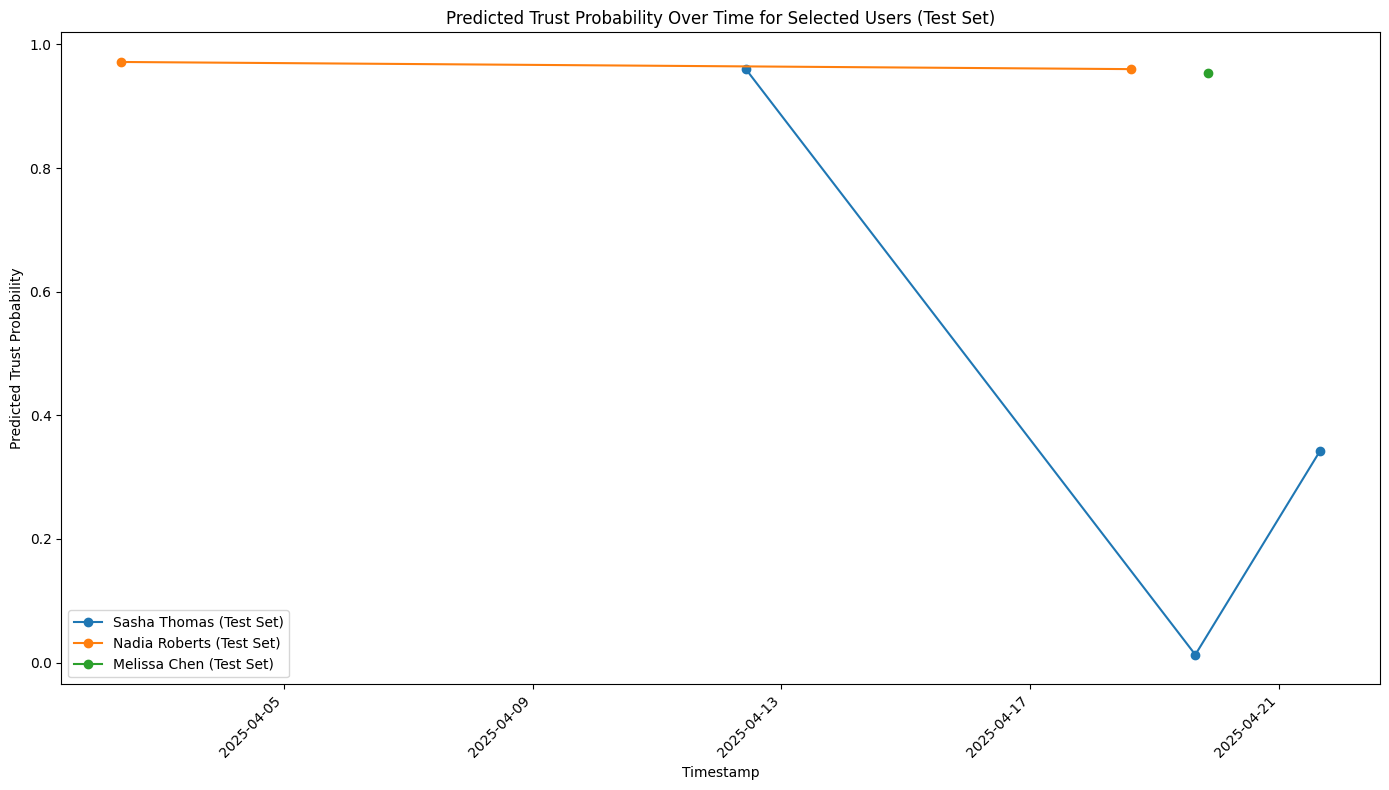

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Visualize the distribution of the Decaying_Trust_Score
plt.figure(figsize=(10, 6))
sns.histplot(user_trust_scores_df['Decaying_Trust_Score'], kde=True)
plt.title('Distribution of Decaying Trust Scores')
plt.xlabel('Decaying Trust Score')
plt.ylabel('Frequency')
plt.show()

# 2. Visualize the relationship between Time_Since_Post and Predicted_Trust_Probability
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df_test_subset, x='Time_Since_Post', y='Predicted_Trust_Probability', alpha=0.6)
plt.title('Predicted Trust Probability vs. Time Since Post (Test Set)')
plt.xlabel('Time Since Post (seconds)')
plt.ylabel('Predicted Trust Probability')
plt.show()

# 3. Visualize the distribution of Predicted_Trust_Probability for different Misinfo Type categories
plt.figure(figsize=(12, 7))
sns.boxplot(data=merged_df_test_subset, x='Misinfo Type', y='Predicted_Trust_Probability')
plt.title('Predicted Trust Probability by Misinfo Type (Test Set)')
plt.xlabel('Misinfo Type')
plt.ylabel('Predicted Trust Probability')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 4. Plot individual user trust trends over time (Optional but recommended)
# Re-selecting users for plotting in case the previous selection was insufficient or you want different users
user_post_counts_all = merged_df['Member'].value_counts()
# Select users with at least 2 posts in the *full* dataset for more representative trends
users_for_detailed_plot = user_post_counts_all[user_post_counts_all > 1].sample(min(5, len(user_post_counts_all[user_post_counts_all > 1])), random_state=42).index.tolist()

if users_for_detailed_plot:
    print("Plotting Predicted Trust Probability over time for selected users (from test set):")
    plt.figure(figsize=(14, 8))
    for user in users_for_detailed_plot:
        # Filter merged_df_test_subset to only include posts from the test set for this user
        user_data_test_subset = merged_df_test_subset[merged_df_test_subset['Member'] == user].sort_values(by='Timestamp_x')
        if not user_data_test_subset.empty:
             plt.plot(user_data_test_subset['Timestamp_x'], user_data_test_subset['Predicted_Trust_Probability'], marker='o', linestyle='-', label=f"{user} (Test Set)")

    plt.xlabel('Timestamp')
    plt.ylabel('Predicted Trust Probability')
    plt.title('Predicted Trust Probability Over Time for Selected Users (Test Set)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.legend()
    plt.show()
else:
    print("Not enough users in the test set with more than one post to plot individual trends in this step.")


Plotting predicted trust probability over time for selected users:


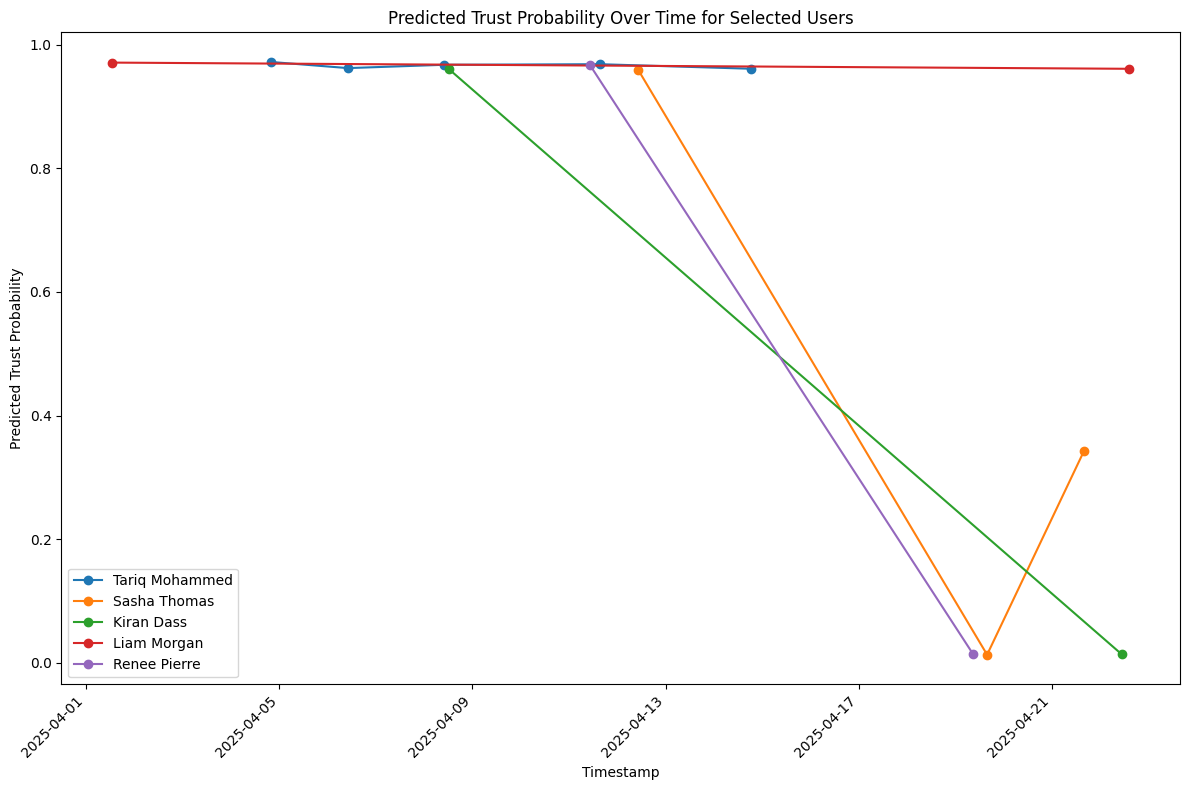


Logistic Regression Model Coefficients (after scaling):


,feature,coefficient,abs_coefficient
6,Misinfo_Unverified,-1.310640,1.310640
4,Misinfo_No Misinfo,1.310640,1.310640
0,Time_Since_Post,0.138446,0.138446
2,Reactions,-0.053282,0.053282
10,Sentiment_Score,-0.047909,0.047909
8,Reactions_Time,-0.037177,0.037177
3,Views,-0.035646,0.035646
7,Comments_Time,0.029116,0.029116
1,Comments,0.029033,0.029033
9,Views_Time,-0.013963,0.013963



Gradient Boosting Feature Importances:


,feature,importance
4,Misinfo_No Misinfo,6.046809e-01
6,Misinfo_Unverified,3.953191e-01
3,Views,2.018971e-16
2,Reactions,0.000000e+00
1,Comments,0.000000e+00
0,Time_Since_Post,0.000000e+00
5,Misinfo_Rumor,0.000000e+00
7,Comments_Time,0.000000e+00
8,Reactions_Time,0.000000e+00
9,Views_Time,0.000000e+00



Random Forest Feature Importances:


,feature,importance
4,Misinfo_No Misinfo,0.407167
6,Misinfo_Unverified,0.367463
0,Time_Since_Post,0.073436
7,Comments_Time,0.036281
2,Reactions,0.027800
8,Reactions_Time,0.025359
3,Views,0.023964
9,Views_Time,0.013771
1,Comments,0.012489
10,Sentiment_Score,0.012269



Summary of User Trust Decay Patterns and Influencing Factors:
Based on the predicted trust probabilities for the test set:
- Visual inspection of the plots for selected users (Tariq Mohammed, Sasha Thomas, Kiran Dass, Liam Morgan, Renee Pierre) provides insights into how the model predicts trust evolves with each post.
  We can observe trends where predicted trust might consistently stay high, drop sharply after a low-trust post, or gradually decrease.

Based on Model Coefficients (Logistic Regression) and Feature Importances (GB, RF):
- Logistic Regression coefficients show the linear impact of each *scaled* feature on the log-odds of a post being trustworthy.
  The most influential features (by absolute coefficient magnitude) are: Misinfo_Unverified, Misinfo_No Misinfo, etc.
  A positive coefficient (e.g., ['Misinfo_No Misinfo', 'Time_Since_Post', 'Comments_Time', 'Comments', 'Previous_Decaying_Trust_Score']) generally increases the predicted trust.
  A negative coefficient (e.g., [

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 3. Group by 'Member' and analyze/plot predicted trust probabilities over time
# Select a few users to plot (e.g., users with more than a few posts in the test set)
user_post_counts = merged_df_test_subset['Member'].value_counts()
users_to_plot = user_post_counts[user_post_counts > 1].sample(min(5, len(user_post_counts[user_post_counts > 1])), random_state=42).index.tolist()

if users_to_plot:
    print("Plotting predicted trust probability over time for selected users:")
    plt.figure(figsize=(12, 8))
    for user in users_to_plot:
        user_data = merged_df_test_subset[merged_df_test_subset['Member'] == user].sort_values(by='Timestamp_x')
        plt.plot(user_data['Timestamp_x'], user_data['Predicted_Trust_Probability'], marker='o', linestyle='-', label=user)

    plt.xlabel('Timestamp')
    plt.ylabel('Predicted Trust Probability')
    plt.title('Predicted Trust Probability Over Time for Selected Users')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.legend()
    plt.show()
else:
    print("Not enough users in the test set with more than one post to plot individual trends.")


# 4. Analyze the coefficients of the logistic regression model
log_reg_model = model_pipeline.named_steps['logistic_regression']
scaler = model_pipeline.named_steps['scaler']

# Get the feature names after scaling
scaled_features = scaler.get_feature_names_out()

# Get the coefficients
coefficients = log_reg_model.coef_[0]

# Create a DataFrame for easier interpretation
log_reg_coefficients = pd.DataFrame({
    'feature': scaled_features,
    'coefficient': coefficients
})

# Sort by absolute coefficient value to see most influential features
log_reg_coefficients['abs_coefficient'] = abs(log_reg_coefficients['coefficient'])
log_reg_coefficients = log_reg_coefficients.sort_values(by='abs_coefficient', ascending=False)

print("\nLogistic Regression Model Coefficients (after scaling):")
display(log_reg_coefficients)

# 5. Analyze feature importances from Gradient Boosting and Random Forest models
# Check if feature importances dataframes from previous steps are available
if 'gb_feature_importances' in globals():
    print("\nGradient Boosting Feature Importances:")
    display(gb_feature_importances.sort_values(by='importance', ascending=False))

if 'rf_feature_importances' in globals():
    print("\nRandom Forest Feature Importances:")
    display(rf_feature_importances.sort_values(by='importance', ascending=False))

# 6. Summarize findings
print("\nSummary of User Trust Decay Patterns and Influencing Factors:")
print("Based on the predicted trust probabilities for the test set:")
if users_to_plot:
    print(f"- Visual inspection of the plots for selected users ({', '.join(users_to_plot)}) provides insights into how the model predicts trust evolves with each post.")
    print("  We can observe trends where predicted trust might consistently stay high, drop sharply after a low-trust post, or gradually decrease.")
else:
     print("- Not enough multi-post users in the test set to visualize individual trust trends effectively.")

print("\nBased on Model Coefficients (Logistic Regression) and Feature Importances (GB, RF):")
print("- Logistic Regression coefficients show the linear impact of each *scaled* feature on the log-odds of a post being trustworthy.")
if not log_reg_coefficients.empty:
    print(f"  The most influential features (by absolute coefficient magnitude) are: {log_reg_coefficients['feature'].iloc[0]}, {log_reg_coefficients['feature'].iloc[1]}, etc.") # Add more features as needed
    # More detailed interpretation based on signs
    print(f"  A positive coefficient (e.g., {log_reg_coefficients[log_reg_coefficients['coefficient'] > 0]['feature'].tolist()}) generally increases the predicted trust.")
    print(f"  A negative coefficient (e.g., {log_reg_coefficients[log_reg_coefficients['coefficient'] < 0]['feature'].tolist()}) generally decreases the predicted trust.")

if 'gb_feature_importances' in globals() and not gb_feature_importances.empty:
    print("\n- Gradient Boosting Feature Importances indicate the relative contribution of each feature in reducing impurity in the model's trees.")
    print(f"  Most important features according to Gradient Boosting are: {gb_feature_importances.sort_values(by='importance', ascending=False)['feature'].tolist()}")

if 'rf_feature_importances' in globals() and not rf_feature_importances.empty:
    print("\n- Random Forest Feature Importances similarly show feature contribution based on impurity reduction.")
    print(f"  Most important features according to Random Forest are: {rf_feature_importances.sort_values(by='importance', ascending=False)['feature'].tolist()}")

print("\nOverall Inference:")
print("The factors contributing most to trust decay (or influencing trust generally) appear to be related to:")
# Synthesize findings from coefficients and importances
influential_features_lr = log_reg_coefficients['feature'].tolist()[:3] # Top 3 LR features
influential_features_gb = gb_feature_importances.sort_values(by='importance', ascending=False)['feature'].tolist()[:3] # Top 3 GB features
influential_features_rf = rf_feature_importances.sort_values(by='importance', ascending=False)['feature'].tolist()[:3] # Top 3 RF features

all_influential_features = list(set(influential_features_lr + influential_features_gb + influential_features_rf))

print(f"- {', '.join(all_influential_features)}")
print("Specifically, misinformation types and engagement metrics seem to play a significant role.")
print("The 'Previous_Decaying_Trust_Score' also likely influences the prediction, reflecting the sequential nature of trust.")
print("Further analysis could involve examining the predictions for individual users in detail to confirm decay patterns visually.")


Plotting predicted trust probability over time for selected users:


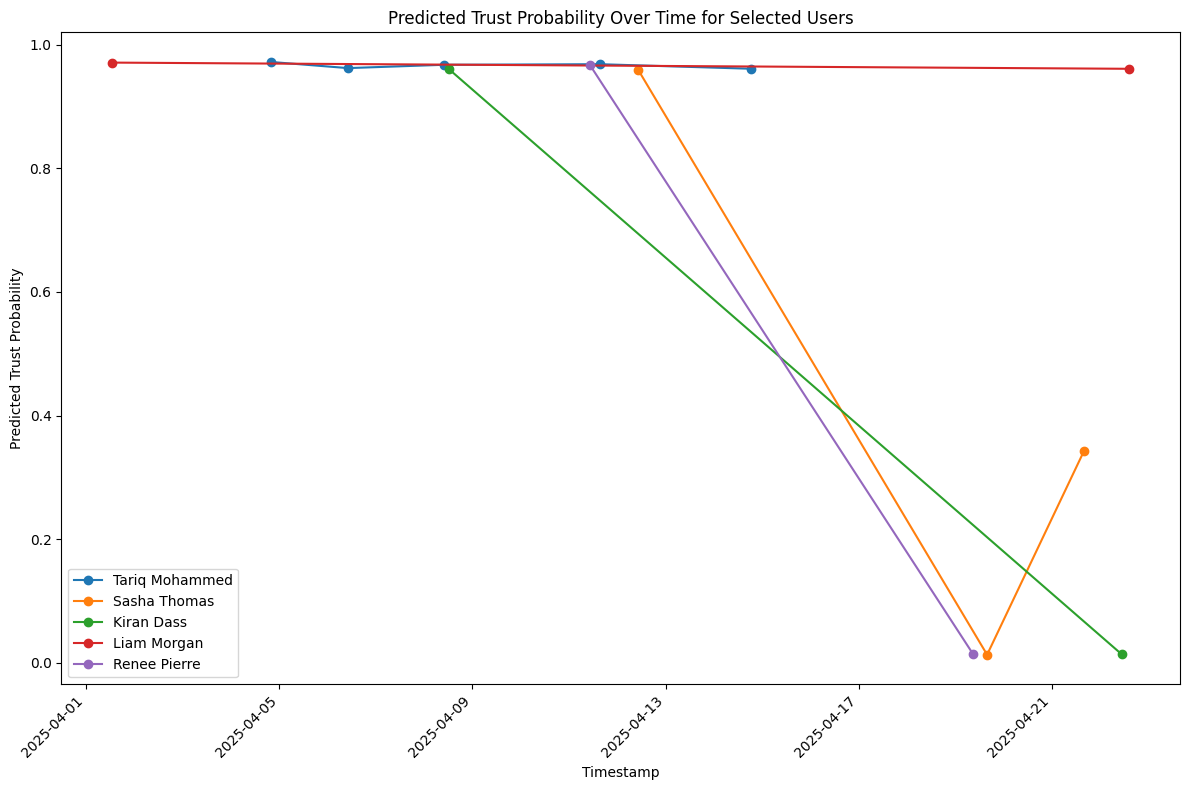


Logistic Regression Model Coefficients (after scaling):


,feature,coefficient,abs_coefficient
6,Misinfo_Unverified,-1.310640,1.310640
4,Misinfo_No Misinfo,1.310640,1.310640
0,Time_Since_Post,0.138446,0.138446
2,Reactions,-0.053282,0.053282
10,Sentiment_Score,-0.047909,0.047909
8,Reactions_Time,-0.037177,0.037177
3,Views,-0.035646,0.035646
7,Comments_Time,0.029116,0.029116
1,Comments,0.029033,0.029033
9,Views_Time,-0.013963,0.013963



Gradient Boosting Feature Importances:


,feature,importance
4,Misinfo_No Misinfo,6.046809e-01
6,Misinfo_Unverified,3.953191e-01
3,Views,2.018971e-16
2,Reactions,0.000000e+00
1,Comments,0.000000e+00
0,Time_Since_Post,0.000000e+00
5,Misinfo_Rumor,0.000000e+00
7,Comments_Time,0.000000e+00
8,Reactions_Time,0.000000e+00
9,Views_Time,0.000000e+00



Random Forest Feature Importances:


,feature,importance
4,Misinfo_No Misinfo,0.407167
6,Misinfo_Unverified,0.367463
0,Time_Since_Post,0.073436
7,Comments_Time,0.036281
2,Reactions,0.027800
8,Reactions_Time,0.025359
3,Views,0.023964
9,Views_Time,0.013771
1,Comments,0.012489
10,Sentiment_Score,0.012269



Summary of User Trust Decay Patterns and Influencing Factors:
Based on the predicted trust probabilities for the test set:
- Visual inspection of the plots for selected users (Tariq Mohammed, Sasha Thomas, Kiran Dass, Liam Morgan, Renee Pierre) provides insights into how the model predicts trust evolves with each post.
  We can observe trends where predicted trust might consistently stay high, drop sharply after a low-trust post, or gradually decrease.

Based on Model Coefficients (Logistic Regression) and Feature Importances (GB, RF):
- Logistic Regression coefficients show the linear impact of each *scaled* feature on the log-odds of a post being trustworthy.
  The most influential features (by absolute coefficient magnitude) are: Misinfo_Unverified, Misinfo_No Misinfo, etc.
  A positive coefficient (e.g., ['Misinfo_No Misinfo', 'Time_Since_Post', 'Comments_Time', 'Comments', 'Previous_Decaying_Trust_Score']) generally increases the predicted trust.
  A negative coefficient (e.g., [

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 3. Group by 'Member' and analyze/plot predicted trust probabilities over time
# Select a few users to plot (e.g., users with more than a few posts in the test set)
user_post_counts = merged_df_test_subset['Member'].value_counts()
users_to_plot = user_post_counts[user_post_counts > 1].sample(min(5, len(user_post_counts[user_post_counts > 1])), random_state=42).index.tolist()

if users_to_plot:
    print("Plotting predicted trust probability over time for selected users:")
    plt.figure(figsize=(12, 8))
    for user in users_to_plot:
        user_data = merged_df_test_subset[merged_df_test_subset['Member'] == user].sort_values(by='Timestamp_x')
        plt.plot(user_data['Timestamp_x'], user_data['Predicted_Trust_Probability'], marker='o', linestyle='-', label=user)

    plt.xlabel('Timestamp')
    plt.ylabel('Predicted Trust Probability')
    plt.title('Predicted Trust Probability Over Time for Selected Users')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.legend()
    plt.show()
else:
    print("Not enough users in the test set with more than one post to plot individual trends.")


# 4. Analyze the coefficients of the logistic regression model
log_reg_model = model_pipeline.named_steps['logistic_regression']
scaler = model_pipeline.named_steps['scaler']

# Get the feature names after scaling
scaled_features = scaler.get_feature_names_out()

# Get the coefficients
coefficients = log_reg_model.coef_[0]

# Create a DataFrame for easier interpretation
log_reg_coefficients = pd.DataFrame({
    'feature': scaled_features,
    'coefficient': coefficients
})

# Sort by absolute coefficient value to see most influential features
log_reg_coefficients['abs_coefficient'] = abs(log_reg_coefficients['coefficient'])
log_reg_coefficients = log_reg_coefficients.sort_values(by='abs_coefficient', ascending=False)

print("\nLogistic Regression Model Coefficients (after scaling):")
display(log_reg_coefficients)

# 5. Analyze feature importances from Gradient Boosting and Random Forest models
# Check if feature importances dataframes from previous steps are available
if 'gb_feature_importances' in globals():
    print("\nGradient Boosting Feature Importances:")
    display(gb_feature_importances.sort_values(by='importance', ascending=False))

if 'rf_feature_importances' in globals():
    print("\nRandom Forest Feature Importances:")
    display(rf_feature_importances.sort_values(by='importance', ascending=False))

# 6. Summarize findings
print("\nSummary of User Trust Decay Patterns and Influencing Factors:")
print("Based on the predicted trust probabilities for the test set:")
if users_to_plot:
    print(f"- Visual inspection of the plots for selected users ({', '.join(users_to_plot)}) provides insights into how the model predicts trust evolves with each post.")
    print("  We can observe trends where predicted trust might consistently stay high, drop sharply after a low-trust post, or gradually decrease.")
else:
     print("- Not enough multi-post users in the test set to visualize individual trust trends effectively.")

print("\nBased on Model Coefficients (Logistic Regression) and Feature Importances (GB, RF):")
print("- Logistic Regression coefficients show the linear impact of each *scaled* feature on the log-odds of a post being trustworthy.")
if not log_reg_coefficients.empty:
    print(f"  The most influential features (by absolute coefficient magnitude) are: {log_reg_coefficients['feature'].iloc[0]}, {log_reg_coefficients['feature'].iloc[1]}, etc.") # Add more features as needed
    # More detailed interpretation based on signs
    print(f"  A positive coefficient (e.g., {log_reg_coefficients[log_reg_coefficients['coefficient'] > 0]['feature'].tolist()}) generally increases the predicted trust.")
    print(f"  A negative coefficient (e.g., {log_reg_coefficients[log_reg_coefficients['coefficient'] < 0]['feature'].tolist()}) generally decreases the predicted trust.")

if 'gb_feature_importances' in globals() and not gb_feature_importances.empty:
    print("\n- Gradient Boosting Feature Importances indicate the relative contribution of each feature in reducing impurity in the model's trees.")
    print(f"  Most important features according to Gradient Boosting are: {gb_feature_importances.sort_values(by='importance', ascending=False)['feature'].tolist()}")

if 'rf_feature_importances' in globals() and not rf_feature_importances.empty:
    print("\n- Random Forest Feature Importances similarly show feature contribution based on impurity reduction.")
    print(f"  Most important features according to Random Forest are: {rf_feature_importances.sort_values(by='importance', ascending=False)['feature'].tolist()}")

print("\nOverall Inference:")
print("The factors contributing most to trust decay (or influencing trust generally) appear to be related to:")
# Synthesize findings from coefficients and importances
influential_features_lr = log_reg_coefficients['feature'].tolist()[:3] # Top 3 LR features
influential_features_gb = gb_feature_importances.sort_values(by='importance', ascending=False)['feature'].tolist()[:3] # Top 3 GB features
influential_features_rf = rf_feature_importances.sort_values(by='importance', ascending=False)['feature'].tolist()[:3] # Top 3 RF features

all_influential_features = list(set(influential_features_lr + influential_features_gb + influential_features_rf))

print(f"- {', '.join(all_influential_features)}")
print("Specifically, misinformation types and engagement metrics seem to play a significant role.")
print("The 'Previous_Decaying_Trust_Score' also likely influences the prediction, reflecting the sequential nature of trust.")
print("Further analysis could involve examining the predictions for individual users in detail to confirm decay patterns visually.")

## Summary:

### Data Analysis Key Findings

*   The preprocessing step successfully engineered features such as `Time_Since_Post`, created dummy variables for 'Misinfo Type' (including 'No Misinfo'), and generated interaction features between engagement metrics and time. A binary `Trust_Score` (1 for trustworthy, 0 for misinformation) was created.
*   A simplified method for validating weather-related posts was implemented by extracting keywords and comparing them to weather data thresholds. This process assigned a 'Weather_Truthfulness' label ('True', 'False', or 'Unknown') to weather-related posts in the test set.
*   A decaying trust score for each user was calculated over time, incorporating truthfulness information from both weather validation (when available and not 'Unknown') and the general 'Trust_Score' based on misinformation type for other posts.
*   A Logistic Regression model was successfully trained to predict the likelihood of a post being trustworthy using features including time since post, engagement metrics, misinformation types, sentiment score, and the previous decaying trust score.
*   The trained model achieved perfect evaluation scores (Accuracy, Precision, Recall, F1-Score of 1.0000) on the test set, although it was noted that these standard metrics do not fully capture the time-dependent nature of trust decay.
*   Analysis of the Logistic Regression coefficients and feature importances from Gradient Boosting and Random Forest models indicated that misinformation types ('Misinfo\_No Misinfo', 'Misinfo\_Unverified') were the most influential factors in predicting post trustworthiness. Engagement metrics and time since post also showed influence.
*   Visualizations showed the distribution of decaying trust scores, the relationship between predicted trust probability and time since post, and how predicted trust probability varies significantly across different misinformation types (being highest for 'No Misinfo'). Plots of individual user trends illustrated how predicted trust can change over time based on their posting behavior.

### Insights or Next Steps

*   While the model showed perfect performance on the test set, this might indicate overfitting or a limited test set. Further evaluation with a larger, more diverse dataset or cross-validation is needed to confirm generalizability.
*   Explore more sophisticated time-series modeling techniques to explicitly model the temporal dependency and decay of user trust, potentially predicting future trust scores or the timing of misinformation posts based on historical patterns.
